# Time Series Anomaly Detection

<u>Scenario</u>: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum?

We will accomplish this by breaking down to the following tasks:

1. Acquire the data
1. Prepare the data
1. Make the analysis process (which we will discuss later) work over all users.
1. Turn the analysis process and calculations into a function that can be used to loop through for each user.
1. Test the function on a single user.
1. Analyze by looping over all users.

The analysis process will look like this, for each user:

1. Compute necessary metrics to arrive at the final metric, %b (percent-b).
1. Add user id to the dataframe that contains all the metrics, including %b.
1. Filter to rows where %b indicates anomaly (i.e. > 1)
1. Append rows of anomalies of new user to previous users' anomalous activity.

Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do!

Your exercise will be to add comments, markdown, and docstrings to the code in this lesson.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

## Acquire

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [2]:
# url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

# query = '''
# SELECT date,
#        path as endpoint,
#        user_id,
#        cohort_id,
#        ip as source_ip
# FROM logs;
# '''
# df0 = pd.read_sql(query, url)

In [4]:
# i'll read it in from a cached version
df0 = pd.read_csv('cached_logs.csv')

In [5]:
# d0, because I intend to resample this by count via day
df0

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
900218,2021-04-21,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


### If I want to look at this like a time series analysis:
 - pd.to_datetime()
 - set_index()

In [6]:
df0['date'] = pd.to_datetime(df0['date'])
df0 = df0.set_index('date')

In [10]:
df0.head()

,endpoint,user_id,cohort_id,source_ip
date,,,,
2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [11]:
# counts of all the rows for endpoint based on day:
df_resampled = df0.resample('D').endpoint.count()

In [12]:
df_resampled.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

### Exponential Moving Average
Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

When we define span in the case of our exponential weighted window,
we need to be mindful that the span is the number of samples

In this case, we are looking at a 7 day exponential moving average
which is because we already resampled by day, so we are taking that EMA on the 7 day window

In [13]:
df_resampled.ewm(span=7).mean()

date
2018-01-26     572.000000
2018-01-27     376.571429
2018-01-28     287.243243
2018-01-29     485.737143
2018-01-30     540.235595
                 ...     
2021-04-17    1303.458794
2021-04-18    1142.344096
2021-04-19    1395.758072
2021-04-20    1529.318554
2021-04-21    1429.738915
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [14]:
# let's calculate a few different moving averages
# original values: df_resampled
weekly = df_resampled.ewm(span=7).mean()
biweekly = df_resampled.ewm(span=14).mean()
monthly = df_resampled.ewm(span=30).mean()
quarterly = df_resampled.ewm(span=90).mean()

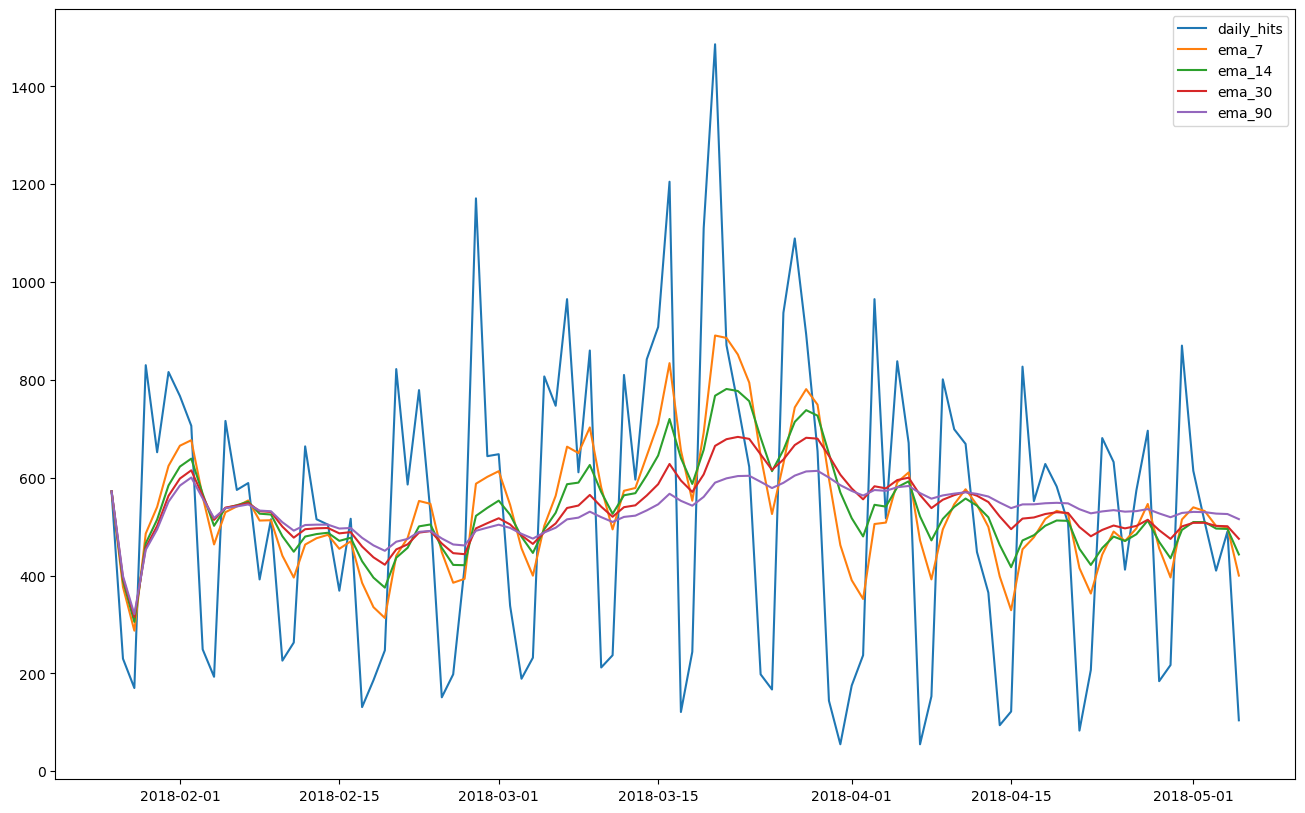

In [15]:
# lets plot the individual emas
fig, ax =  plt.subplots(figsize=(16,10))
ax.plot(df_resampled[:100], label='daily_hits')
ax.plot(weekly[:100], label='ema_7')
ax.plot(biweekly[:100], label='ema_14')
ax.plot(monthly[:100], label='ema_30')
ax.plot(quarterly[:100], label='ema_90')
ax.legend()
plt.show()

In [16]:
# we can also calculate the standard deviation based on the exponential window
df_resampled.ewm(span=7).std()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    203.001930
2018-01-29    343.010938
2018-01-30    287.326077
                 ...    
2021-04-17    735.037572
2021-04-18    704.317390
2021-04-19    772.536401
2021-04-20    714.173492
2021-04-21    645.940553
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [18]:
# calculating our bollinger bands:
# lets go for a span of 30
# lets say, 3 standard deviations out (k=3)
n = 30
k = 3
ema_30 = df_resampled.ewm(span=n).mean()
std_30 = df_resampled.ewm(span=n).std()
# upper and lower bands:
#  upper band: ema + k * std
#  lower band: ema - k + std
upper_band = ema_30 + k*std_30
lower_band = ema_30 - k*std_30

In [19]:
# building a bollinger band df:
bb_df = pd.concat([df_resampled,
                   ema_30,
                   upper_band,
                   lower_band], axis=1)
bb_df.columns = ['page_count',
                 'midband',
                 'ub',
                 'lb']

In [20]:
bb_df

,page_count,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116
...,...,...,...,...
2021-04-17,478,1325.179115,3545.216722,-894.858492
2021-04-18,659,1282.199817,3486.733695,-922.334061
2021-04-19,2156,1338.574023,3569.147958,-891.999913


In [21]:
# percent b is going to be my (data point - lower band) / (upper - lower)
bb_df['prcnt_b'] = (bb_df.page_count - bb_df.lb) / (
    bb_df['ub'] - bb_df['lb'])

In [22]:
bb_df

,page_count,midband,ub,lb,prcnt_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249
...,...,...,...,...,...
2021-04-17,478,1325.179115,3545.216722,-894.858492,0.309197
2021-04-18,659,1282.199817,3486.733695,-922.334061,0.358655
2021-04-19,2156,1338.574023,3569.147958,-891.999913,0.683232


In [23]:
bb_df[bb_df.prcnt_b >=1]

,page_count,midband,ub,lb,prcnt_b
date,,,,,


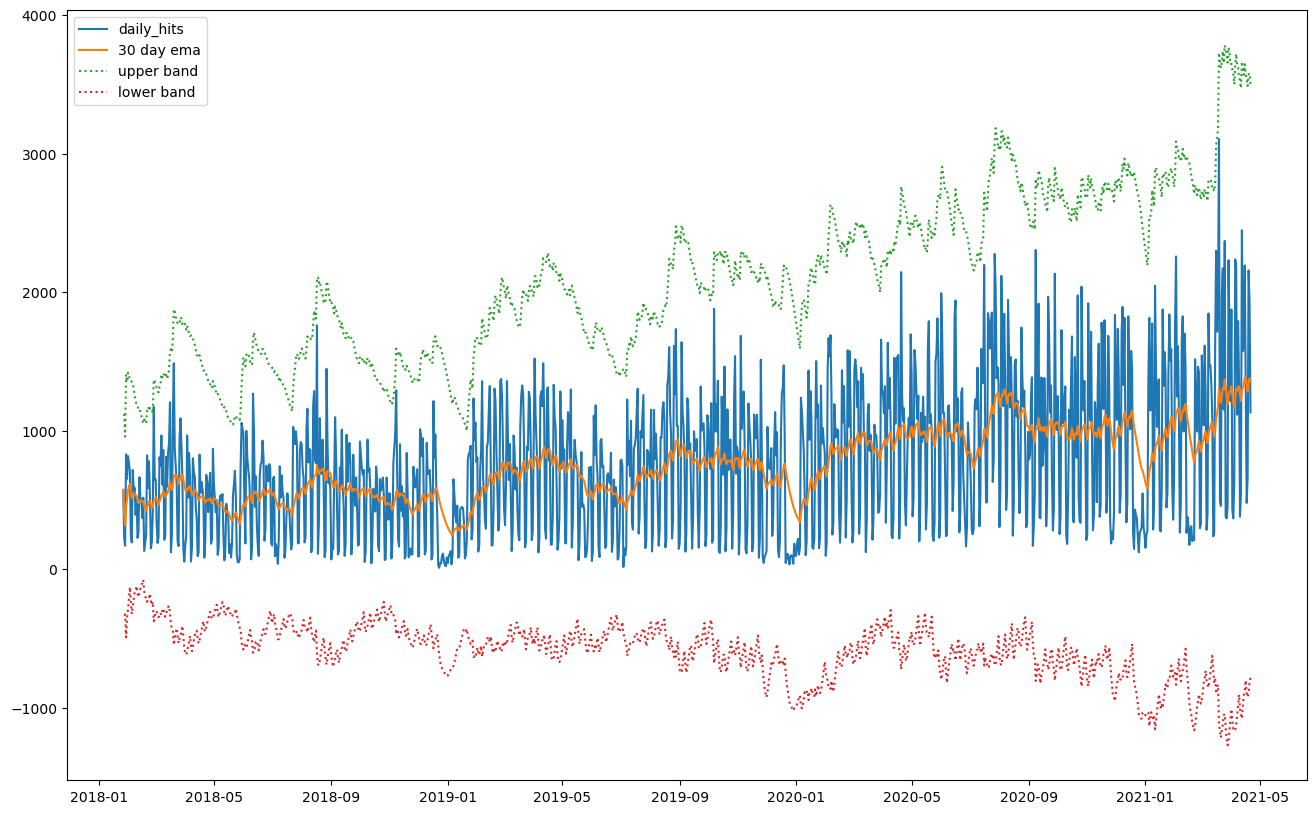

In [24]:
# lets plot the individual emas
fig, ax =  plt.subplots(figsize=(16,10))
ax.plot(bb_df['page_count'], label='daily_hits')
ax.plot(bb_df['midband'], label='30 day ema')
ax.plot(bb_df['ub'], label='upper band', ls=':')
ax.plot(bb_df['lb'], label='lower band', ls=':')
ax.legend()
plt.show()

In [25]:
df0.columns

Index(['endpoint', 'user_id', 'cohort_id', 'source_ip'], dtype='object')

In [26]:
# what if for one user?
def get_user(df, user_id):
    # narrow down the dataframe to each user's activity on a day by day basis
    return df[df.user_id == user_id].resample('D').endpoint.count()

In [38]:
def get_user_bb(user_df, user_id, span=30, k=3):
    # calculating the bollinger bands the same way we did prior, 
    # but with the individual user resampled df
    # user_df is the sampled dataframe for a user by page count per day 
    ema = user_df.ewm(span=span).mean()
    std = user_df.ewm(span=span).std()
    upper_band = ema + k*std
    lower_band = ema - k*std
    # make a little bb_df for the user:
    bb_df = pd.concat([user_df,
                   ema,
                   upper_band,
                   lower_band], axis=1)
    # make sure the column names make sense:
    bb_df.columns = ['page_count',
                 'midband',
                 'ub',
                 'lb']
    # calculate the %b for that user:
    bb_df['prcnt_b'] = (bb_df.page_count - bb_df.lb) / (
    bb_df['ub'] - bb_df['lb'])
    # NEW STEP! add in the user id so if we look at these together we know who it was :)
    bb_df['user_id'] = user_id
    # return the bb_df for that user
    return bb_df

In [39]:
# using the function get_user_bb nested on get_user for the user with id 1:
bb_df = get_user_bb(get_user(df0, user_id=1), user_id=1)

In [60]:
def get_anomalies(df, user_id, k=3, span=30):
    # get the user resampled Series
    user_df = get_user(df, user_id)
    # calculate the bol-band df for the user:
    bb_df = get_user_bb(user_df, user_id, span=span, k=k)
    # narrow down the entries that are exceptionally high hits for the user
    anomalies = bb_df[bb_df.prcnt_b >=1]
    return anomalies

In [61]:
get_anomalies(df0, 1)

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


In [67]:
# what if we change it to 4 standard deviations out?
get_anomalies(df0, 1, k=4)

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,


In [47]:
# for every user:
# initialize an empty df
df_anomalies = pd.DataFrame()
# for every user in unique user ids of the original df:
for user in df0.user_id.unique():
    # get the anomalies of that user
    user_anomalies = get_anomalies(df0, user_id=user)
    # concatenate the new entries into what we already have present in df_anomalies
    df_anomalies = pd.concat([df_anomalies, user_anomalies], axis=0)

In [49]:
df_anomalies

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
...,...,...,...,...,...,...
2021-04-13,42,6.722117,39.398133,-25.953900,1.039813,884
2021-04-14,67,12.322021,63.449584,-38.805542,1.034721,888
2021-04-20,53,11.548548,50.739988,-27.642892,1.028833,919


In [50]:
# how many high percent b rows by user?
df_anomalies.user_id.value_counts()

user_id
88     21
41     18
80     18
146    18
291    16
       ..
251     1
663     1
243     1
240     1
927     1
Name: count, Length: 610, dtype: int64

In [53]:
# sort them by prcnt b maybe?
df_anomalies.sort_values(by='prcnt_b')

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2020-08-24,79,11.697642,78.944325,-55.549040,1.000414,664
2020-08-03,46,8.801007,45.968542,-28.366528,1.000423,608
2018-08-10,107,16.939655,106.913987,-73.034677,1.000478,223
2020-09-03,62,12.512145,61.945338,-36.921047,1.000553,737
2020-10-17,5,0.531820,4.994405,-3.930765,1.000627,564
...,...,...,...,...,...,...
2020-03-10,8,0.516129,6.513006,-5.480748,1.123981,213
2020-12-07,1,0.064516,0.814126,-0.685094,1.123981,143
2021-01-19,4,0.258065,3.256503,-2.740374,1.123981,308


In [56]:
# what if we sort them by page count?
df_anomalies.sort_values(by='page_count', ascending=False).head()

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2020-07-22,285,44.915959,266.290617,-176.458698,1.042257,11
2019-03-03,272,24.721632,232.200343,-182.757078,1.095913,341
2020-04-16,271,44.194413,267.834945,-179.446120,1.007076,570
2019-07-25,253,34.698961,222.709718,-153.311796,1.080555,422
2020-04-05,232,32.133967,205.731770,-141.463837,1.075658,570


In [57]:
# user 341, 570 and 11 accessed more than 270 pages in a day??

In [58]:
# big if true